# IMPORTS 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# API_ACCESSING_AND_DATASET_CREATION

In [3]:
import requests
import pandas as pd

def fetch_crypto_historical_data(crypto_symbol="BTC", vs_currency="USD", limit=30, api_key="your_api_key"):
    # Endpoint URL for CryptoCompare historical daily data
    url = f"https://min-api.cryptocompare.com/data/v2/histoday"
    params = {
        "fsym": crypto_symbol,
        "tsym": vs_currency,
        "limit": limit,  # Number of days of historical data
        "api_key": api_key
    }
    
    try:
        # Send the GET request
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an exception if the request was unsuccessful
        
        # Parse JSON response
        data = response.json()
        
        # Check if the response contains 'Data'
        if data.get("Response") == "Success" and "Data" in data and "Data" in data["Data"]:
            print(f"Successfully retrieved data for {crypto_symbol} in {vs_currency}.")
            
            # Convert the 'Data' section to a DataFrame
            historical_data = data["Data"]["Data"]
            df = pd.DataFrame(historical_data)
            
            # Convert the 'time' column to a readable date format
            df["time"] = pd.to_datetime(df["time"], unit='s')
            df.rename(columns={'time': 'Date', 'high': 'High', 'low': 'Low', 'open': 'Open', 'close': 'Close'}, inplace=True)
            
            # Save to CSV
            csv_filename = f"{crypto_symbol}_{vs_currency}_historical_data.csv"
            df.to_csv(csv_filename, index=False)
            print(f"Data saved to {csv_filename}")
            
            return df
        else:
            print("No historical data found.")
            return None
        
    except requests.exceptions.RequestException as e:
        print(f"API call failed: {e}")
        return None

# Run the fetch function
df = fetch_crypto_historical_data(crypto_symbol="BTC", vs_currency="USD", limit=2000, api_key="b69129957bd1f8c892c717cc4a79c09fc483d97477548eca9ce67439297be5a8")


Successfully retrieved data for BTC in USD.
Data saved to BTC_USD_historical_data.csv


In [4]:
data=pd.read_csv("BTC_USD_historical_data.csv")

In [5]:
data.head()

,Date,High,Low,Open,volumefrom,volumeto,Close,conversionType,conversionSymbol
0,2019-05-11,7394.94,6357.02,6358.29,135248.42,9.331413e+08,7191.36,direct,NaN
1,2019-05-12,7541.61,6793.21,7191.36,142892.25,1.023203e+09,6977.63,direct,NaN
2,2019-05-13,8127.75,6873.42,6977.63,149082.57,1.140303e+09,7806.36,direct,NaN
3,2019-05-14,8297.02,7631.34,7806.36,122383.06,9.760941e+08,7980.13,direct,NaN
4,2019-05-15,8263.29,7849.92,7980.13,86162.62,6.942028e+08,8183.83,direct,NaN


In [6]:
data.columns

Index(['Date', 'High', 'Low', 'Open', 'volumefrom', 'volumeto', 'Close',
       'conversionType', 'conversionSymbol'],
      dtype='object')

In [7]:
data.isna().sum()

Date                   0
High                   0
Low                    0
Open                   0
volumefrom             0
volumeto               0
Close                  0
conversionType         0
conversionSymbol    2001
dtype: int64

In [8]:
data.count()

Date                2001
High                2001
Low                 2001
Open                2001
volumefrom          2001
volumeto            2001
Close               2001
conversionType      2001
conversionSymbol       0
dtype: int64

In [9]:
data.nunique()

Date                2001
High                2000
Low                 2001
Open                2000
volumefrom          2001
volumeto            2001
Close               2000
conversionType         1
conversionSymbol       0
dtype: int64

# DATA PREPROCESSING

In [15]:
import pandas as pd

# Load the CSV file with historical data
df = pd.read_csv("BTC_USD_historical_data.csv")

# Drop unnecessary columns
df.drop(columns=['conversionType', 'conversionSymbol'], inplace=True)

# Function to calculate metrics
def calculate_metrics(data, variable1=7, variable2=5):
    data = data.copy()  # Work with a copy to avoid modifying the original DataFrame

    # Historical High and Low Prices
    data[f'High_Last_{variable1}_Days'] = data['High'].rolling(window=variable1).max()
    data[f'Low_Last_{variable1}_Days'] = data['Low'].rolling(window=variable1).min()

    # Days Since Historical High/Low
    data[f'Days_Since_High_Last_{variable1}_Days'] = data['High_Last_' + str(variable1) + '_Days'].expanding().apply(
        lambda x: (data['Date'].iloc[len(x) - 1] - data['Date'].iloc[0]).days if len(x.dropna()) > 0 else None
    )
    data[f'Days_Since_Low_Last_{variable1}_Days'] = data['Low_Last_' + str(variable1) + '_Days'].expanding().apply(
        lambda x: (data['Date'].iloc[len(x) - 1] - data['Date'].iloc[0]).days if len(x.dropna()) > 0 else None
    )

    # % Difference from Historical High/Low
    data[f'%_Diff_From_High_Last_{variable1}_Days'] = ((data['Close'] - data[f'High_Last_{variable1}_Days']) / data[f'High_Last_{variable1}_Days']) * 100
    data[f'%_Diff_From_Low_Last_{variable1}_Days'] = ((data['Close'] - data[f'Low_Last_{variable1}_Days']) / data[f'Low_Last_{variable1}_Days']) * 100

    # Future High and Low Prices
    data[f'High_Next_{variable2}_Days'] = data['High'].shift(-variable2).rolling(window=variable2).max()
    data[f'Low_Next_{variable2}_Days'] = data['Low'].shift(-variable2).rolling(window=variable2).min()

    # % Difference from Future High/Low
    data[f'%_Diff_From_High_Next_{variable2}_Days'] = ((data['Close'] - data[f'High_Next_{variable2}_Days']) / data[f'High_Next_{variable2}_Days']) * 100
    data[f'%_Diff_From_Low_Next_{variable2}_Days'] = ((data['Close'] - data[f'Low_Next_{variable2}_Days']) / data[f'Low_Next_{variable2}_Days']) * 100

    return data

# Apply the metrics calculation function
df['Date'] = pd.to_datetime(df['Date'])  # Ensure the Date column is in datetime format
df = calculate_metrics(df)

# Save the processed data with new metrics
processed_csv_filename = "BTC_USD_processed_data.csv"
df.to_csv(processed_csv_filename, index=False)
print(f"Processed data saved to {processed_csv_filename}")


Processed data saved to BTC_USD_processed_data.csv


In [3]:
df=pd.read_csv("BTC_USD_processed_data.csv")
df.head()

,Date,High,Low,Open,volumefrom,volumeto,Close,High_Last_7_Days,Low_Last_7_Days,Days_Since_High_Last_7_Days,Days_Since_Low_Last_7_Days,%_Diff_From_High_Last_7_Days,%_Diff_From_Low_Last_7_Days,High_Next_5_Days,Low_Next_5_Days,%_Diff_From_High_Next_5_Days,%_Diff_From_Low_Next_5_Days
0,2019-05-11,7394.94,6357.02,6358.29,135248.42,9.331413e+08,7191.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-12,7541.61,6793.21,7191.36,142892.25,1.023203e+09,6977.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-13,8127.75,6873.42,6977.63,149082.57,1.140303e+09,7806.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-14,8297.02,7631.34,7806.36,122383.06,9.760941e+08,7980.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-15,8263.29,7849.92,7980.13,86162.62,6.942028e+08,8183.83,NaN,NaN,NaN,NaN,NaN,NaN,8352.25,6668.67,-2.016463,22.720572


In [17]:
df.isna().sum()

Date                            0
High                            0
Low                             0
Open                            0
volumefrom                      0
volumeto                        0
Close                           0
High_Last_7_Days                6
Low_Last_7_Days                 6
Days_Since_High_Last_7_Days     6
Days_Since_Low_Last_7_Days      6
%_Diff_From_High_Last_7_Days    6
%_Diff_From_Low_Last_7_Days     6
High_Next_5_Days                9
Low_Next_5_Days                 9
%_Diff_From_High_Next_5_Days    9
%_Diff_From_Low_Next_5_Days     9
dtype: int64

# FEATURE SELECTION

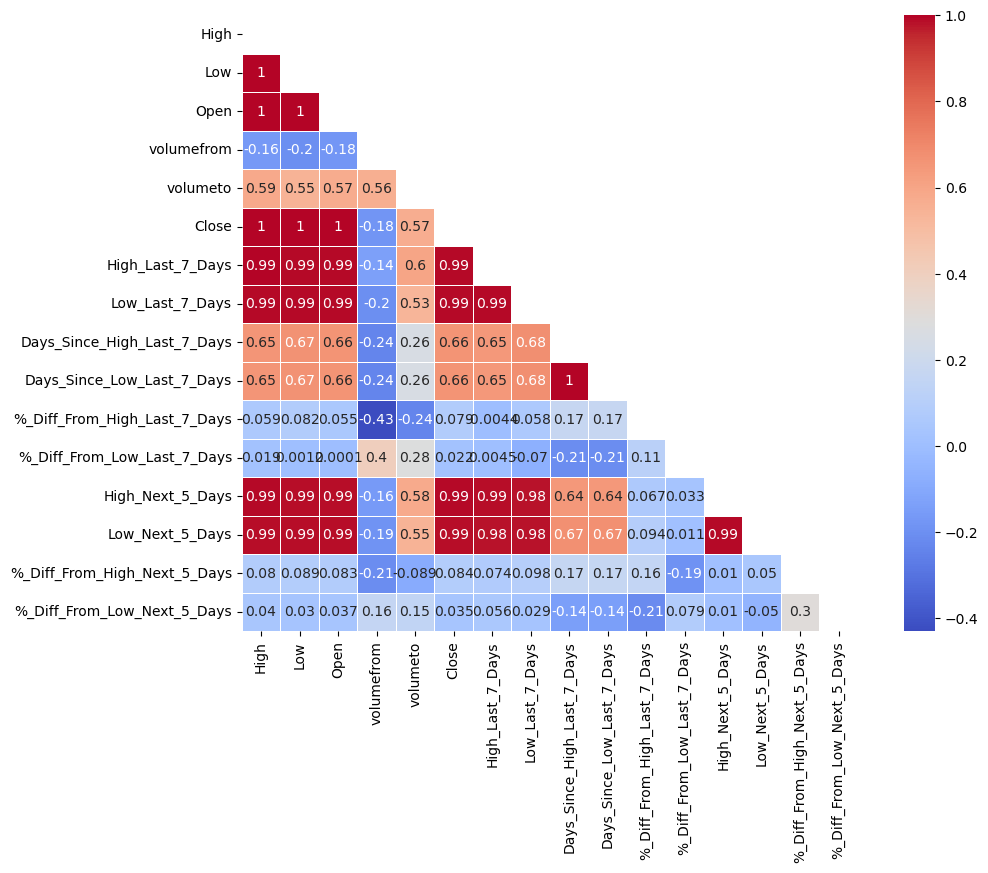

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Step 1: Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Handle NaN values by filling with the mean (or drop them if needed)
df.fillna(df.mean(), inplace=True)

# Step 3: Calculate the correlation matrix excluding the 'Date' column
correlation_matrix = df.drop(columns=['Date']).corr()

# Step 4: Create a mask to display only the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Step 5: Set the size of the heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Step 6: Create the heatmap with the mask
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, square=True, linewidths=.5)

# Show the plot
plt.show()


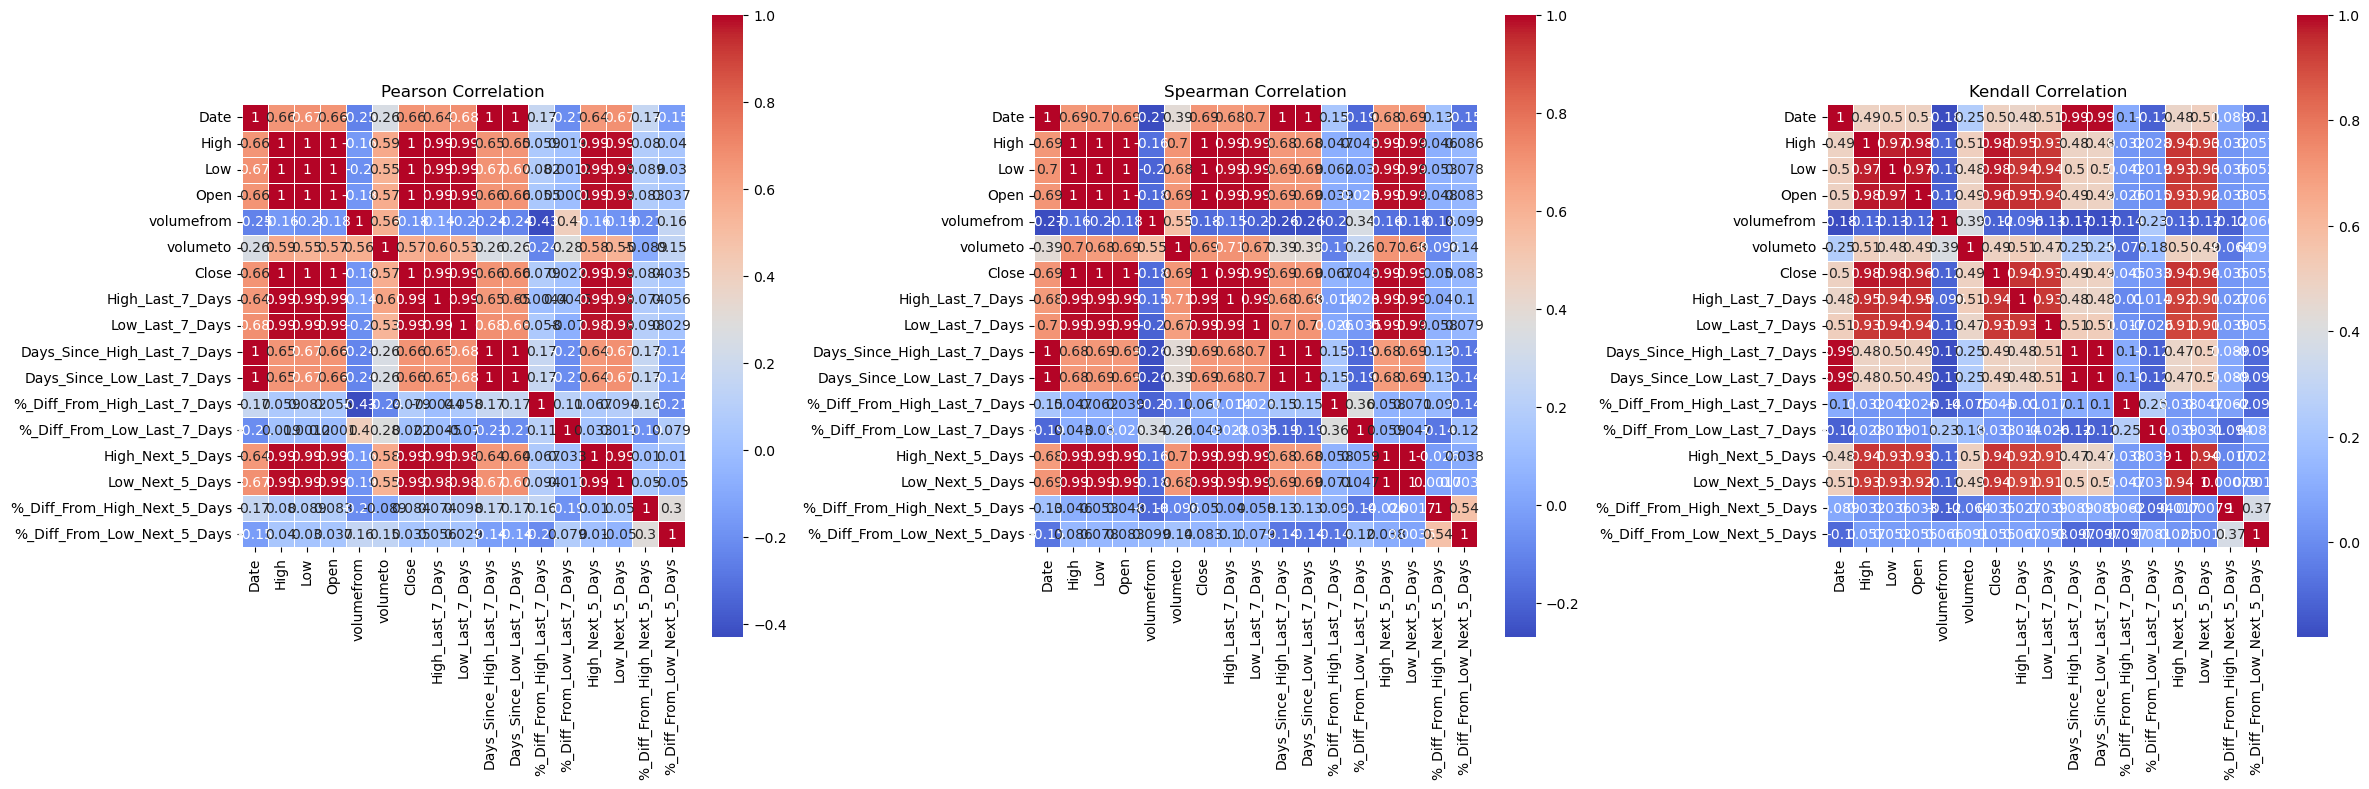

Pearson correlation with target:
High_Next_5_Days                1.000000
Low_Next_5_Days                 0.994034
Close                           0.989289
High                            0.989201
Open                            0.987703
Low                             0.987682
High_Last_7_Days                0.986915
Low_Last_7_Days                 0.983162
Days_Since_Low_Last_7_Days      0.644846
Days_Since_High_Last_7_Days     0.644846
Date                            0.644080
volumeto                        0.577950
%_Diff_From_High_Last_7_Days    0.067003
%_Diff_From_Low_Last_7_Days     0.033142
%_Diff_From_High_Next_5_Days    0.010294
%_Diff_From_Low_Next_5_Days     0.010266
volumefrom                     -0.159532
Name: High_Next_5_Days, dtype: float64

Spearman correlation with target:
High_Next_5_Days                1.000000
Low_Next_5_Days                 0.995129
Close                           0.990093
High                            0.989763
Low                             

In [21]:
# Step 3: Calculate the correlation matrices
pearson_corr = df.corr(method='pearson')
spearman_corr = df.corr(method='spearman')
kendall_corr = df.corr(method='kendall')

# Step 4: Create subplots to visualize the correlation matrices
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Pearson correlation heatmap
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', ax=axes[0], square=True, linewidths=.5)
axes[0].set_title('Pearson Correlation')

# Spearman correlation heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', ax=axes[1], square=True, linewidths=.5)
axes[1].set_title('Spearman Correlation')

# Kendall correlation heatmap
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', ax=axes[2], square=True, linewidths=.5)
axes[2].set_title('Kendall Correlation')

# Step 5: Show the plots
plt.tight_layout()
plt.show()

# Step 6: Optional - Print correlation values for specific target variables
target_variable = 'High_Next_5_Days'  # Change as needed
print("Pearson correlation with target:")
print(pearson_corr[target_variable].sort_values(ascending=False))

print("\nSpearman correlation with target:")
print(spearman_corr[target_variable].sort_values(ascending=False))

print("\nKendall correlation with target:")
print(kendall_corr[target_variable].sort_values(ascending=False))

In [23]:
df.dtypes

Date                            datetime64[ns]
High                                   float64
Low                                    float64
Open                                   float64
volumefrom                             float64
volumeto                               float64
Close                                  float64
High_Last_7_Days                       float64
Low_Last_7_Days                        float64
Days_Since_High_Last_7_Days            float64
Days_Since_Low_Last_7_Days             float64
%_Diff_From_High_Last_7_Days           float64
%_Diff_From_Low_Last_7_Days            float64
High_Next_5_Days                       float64
Low_Next_5_Days                        float64
%_Diff_From_High_Next_5_Days           float64
%_Diff_From_Low_Next_5_Days            float64
dtype: object

In [24]:
df.isnull().sum()

Date                            0
High                            0
Low                             0
Open                            0
volumefrom                      0
volumeto                        0
Close                           0
High_Last_7_Days                0
Low_Last_7_Days                 0
Days_Since_High_Last_7_Days     0
Days_Since_Low_Last_7_Days      0
%_Diff_From_High_Last_7_Days    0
%_Diff_From_Low_Last_7_Days     0
High_Next_5_Days                0
Low_Next_5_Days                 0
%_Diff_From_High_Next_5_Days    0
%_Diff_From_Low_Next_5_Days     0
dtype: int64

In [25]:
df.head()

,Date,High,Low,Open,volumefrom,volumeto,Close,High_Last_7_Days,Low_Last_7_Days,Days_Since_High_Last_7_Days,Days_Since_Low_Last_7_Days,%_Diff_From_High_Last_7_Days,%_Diff_From_Low_Last_7_Days,High_Next_5_Days,Low_Next_5_Days,%_Diff_From_High_Next_5_Days,%_Diff_From_Low_Next_5_Days
0,2019-05-11,7394.94,6357.02,6358.29,135248.42,9.331413e+08,7191.36,33347.284401,29201.002992,1003.0,1003.0,-5.590579,8.103553,33096.160723,29604.950713,-5.289050,6.163275
1,2019-05-12,7541.61,6793.21,7191.36,142892.25,1.023203e+09,6977.63,33347.284401,29201.002992,1003.0,1003.0,-5.590579,8.103553,33096.160723,29604.950713,-5.289050,6.163275
2,2019-05-13,8127.75,6873.42,6977.63,149082.57,1.140303e+09,7806.36,33347.284401,29201.002992,1003.0,1003.0,-5.590579,8.103553,33096.160723,29604.950713,-5.289050,6.163275
3,2019-05-14,8297.02,7631.34,7806.36,122383.06,9.760941e+08,7980.13,33347.284401,29201.002992,1003.0,1003.0,-5.590579,8.103553,33096.160723,29604.950713,-5.289050,6.163275
4,2019-05-15,8263.29,7849.92,7980.13,86162.62,6.942028e+08,8183.83,33347.284401,29201.002992,1003.0,1003.0,-5.590579,8.103553,8352.250000,6668.670000,-2.016463,22.720572


# **Trying different Models to work upon**

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming 'df' is your DataFrame

# Step 1: Prepare your features and target variable
# Drop the 'Date' column and any other non-numeric columns if necessary
X = df.drop(columns=['Date', 'High_Next_5_Days', 'Low_Next_5_Days'])  # Update based on your target column(s)
y = df['High_Next_5_Days']  # Set your target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Make predictions
predictions = model.predict(X_test)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f'R² Score: {r2}')

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_scores.mean()}')


Mean Squared Error: 1143964.6567689516
R² Score: 0.9970819341693369
Cross-Validation MSE: 6594357.441968866


In [28]:
importance = model.coef_
feature_names = X.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))


                         Feature    Importance
10  %_Diff_From_High_Last_7_Days  2.067939e+02
6               High_Last_7_Days  6.031021e-01
5                          Close  4.551105e-01
0                           High  3.098929e-01
3                     volumefrom  7.914858e-03
4                       volumeto -4.588788e-07
8    Days_Since_High_Last_7_Days -3.752105e-02
9     Days_Since_Low_Last_7_Days -3.752105e-02
7                Low_Last_7_Days -4.760385e-02
2                           Open -1.019261e-01
1                            Low -2.119192e-01
11   %_Diff_From_Low_Last_7_Days -1.690119e+01
13   %_Diff_From_Low_Next_5_Days -1.875628e+01
12  %_Diff_From_High_Next_5_Days -3.229735e+02


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest model
rf_model = RandomForestRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best model and its MSE
best_rf_model = grid_search.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)

print(f'Best Random Forest MSE: {rf_mse}')


Best Random Forest MSE: 379805.9978795686


In [31]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df' is your DataFrame containing the dataset
# Define your features (X) and target (y)
X = df.drop(columns=['Date', 'High_Next_5_Days', 'Low_Next_5_Days'])  # Drop unnecessary columns
y = df['Close']  # Set your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the CatBoost model
model = CatBoostRegressor(iterations=1000,  # You can adjust this based on performance
                          learning_rate=0.1,
                          depth=6,
                          l2_leaf_reg=3,
                          eval_metric='RMSE',
                          random_seed=42,
                          verbose=100)  # Verbosity level

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Feature importance
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


0:	learn: 17549.2651853	total: 62.3ms	remaining: 1m 2s
100:	learn: 513.8561240	total: 167ms	remaining: 1.49s
200:	learn: 347.6972311	total: 278ms	remaining: 1.1s
300:	learn: 273.7275714	total: 402ms	remaining: 934ms
400:	learn: 221.7929552	total: 535ms	remaining: 800ms
500:	learn: 184.3571763	total: 689ms	remaining: 687ms
600:	learn: 155.5684449	total: 866ms	remaining: 575ms
700:	learn: 133.3979602	total: 1.03s	remaining: 438ms
800:	learn: 115.3129189	total: 1.19s	remaining: 295ms
900:	learn: 99.4053120	total: 1.34s	remaining: 147ms
999:	learn: 87.9965323	total: 1.5s	remaining: 0us
Mean Squared Error: 157074.91552815866
R² Score: 0.999566433010417
                         Feature  Importance
2                           Open   28.691078
1                            Low   21.840945
6               High_Last_7_Days   14.880453
5                          Close   12.565351
0                           High   12.207940
7                Low_Last_7_Days    3.798776
9     Days_Since_Low_Last_7_D

In [4]:
import catboost
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV

# Prepare your features and target variable
X = df.drop(columns=['Date', 'Close'])  # Adjust as necessary, keep all features
y = df['Close']

# Split your data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)

# Set up parameter grid for hyperparameter tuning
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.5],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [3, 5, 7]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_catboost_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred = best_catboost_model.predict(X_test)

# Calculate Mean Squared Error and R² Score
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best CatBoost MSE: {mse}")
print(f"R² Score: {r2}")


Best CatBoost MSE: 160498.51711116434
R² Score: 0.9995569829933543


In [39]:
import itertools
import warnings
warnings.filterwarnings("ignore")

# Define the range of parameters
p = d = q = range(0, 3)  # Adjust ranges as necessary
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(train, order=param)
        results = model.fit()
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq} with AIC: {best_aic}')


Best ARIMA parameters: (2, 1, 2) with AIC: 26920.814062221987


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60253D+00    |proj g|=  1.71565D-01

At iterate    5    f=  8.58964D+00    |proj g|=  8.50542D-04

At iterate   10    f=  8.58964D+00    |proj g|=  1.51250D-03

At iterate   15    f=  8.58935D+00    |proj g|=  2.02541D-02

At iterate   20    f=  8.58243D+00    |proj g|=  6.32605D-02

At iterate   25    f=  8.57947D+00    |proj g|=  5.87985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   

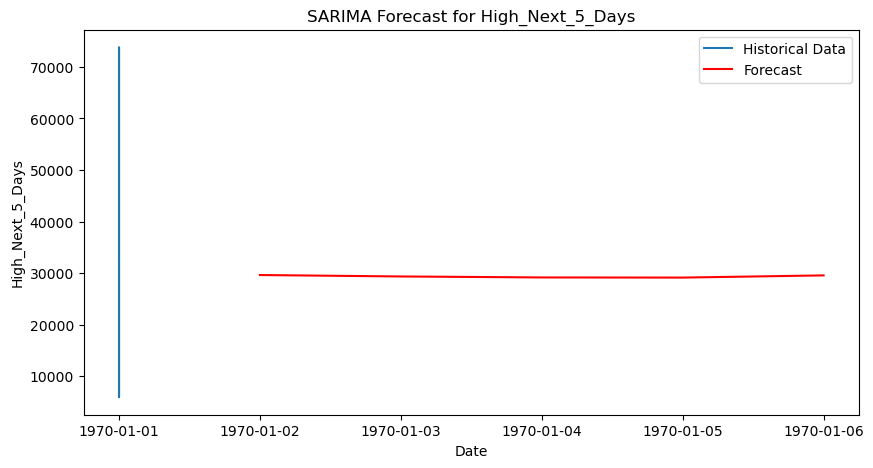

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df is your DataFrame that includes 'High_Next_5_Days'
# Ensure 'High_Next_5_Days' is in the DataFrame
target = df[['High_Next_5_Days']]  # Select the column as a DataFrame

# Convert the index to datetime if it's not already
target.index = pd.to_datetime(target.index)

# Define SARIMA model parameters
order = (5, 1, 0)  # (p, d, q)
seasonal_order = (0, 0, 0, 12)  # (P, D, Q, s)

# Fit the SARIMA model
model = SARIMAX(target['High_Next_5_Days'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Display the model summary
print(results.summary())

# Forecast for the next 5 days
forecast_steps = 5
forecast = results.get_forecast(steps=forecast_steps)

# Create a date index for the forecast
forecast_index = pd.date_range(start=target.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean

# Plot the historical data and forecast
plt.figure(figsize=(10, 5))
plt.plot(target.index, target['High_Next_5_Days'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.title('SARIMA Forecast for High_Next_5_Days')
plt.xlabel('Date')
plt.ylabel('High_Next_5_Days')
plt.legend()
plt.show()


## After comparison settling with the CATBOOST model

**Analysing different aspects to optimise the model**

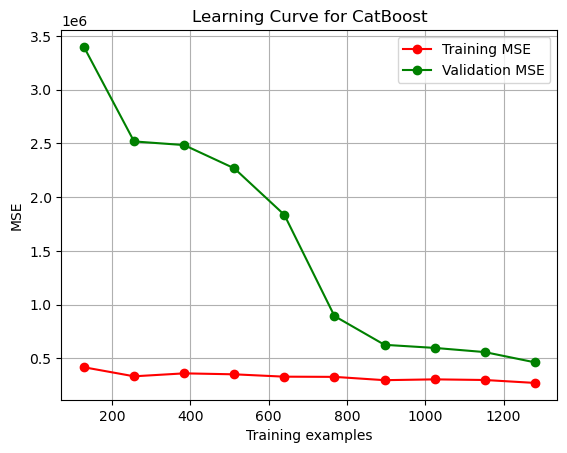

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor

# Define your CatBoost model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, silent=True)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, 
                                                        cv=5, scoring='neg_mean_squared_error',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MSE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation MSE")
plt.xlabel("Training examples")
plt.ylabel("MSE")
plt.title("Learning Curve for CatBoost")
plt.legend(loc="best")
plt.grid()
plt.show()


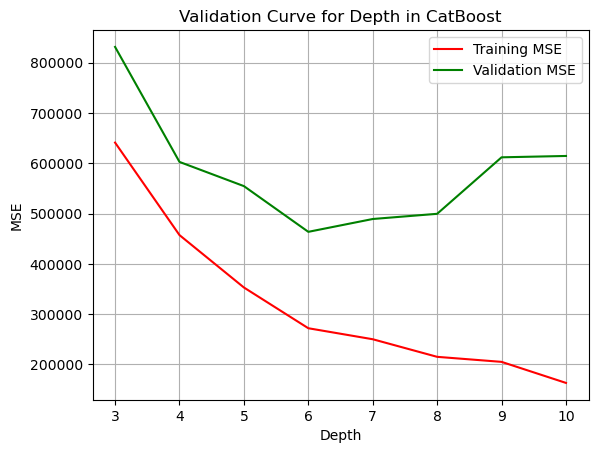

In [6]:
from sklearn.model_selection import validation_curve

# Specify the range of the parameter
param_range = [3, 4, 5, 6, 7, 8, 9, 10]

# Calculate the validation curve
train_scores, test_scores = validation_curve(
    CatBoostRegressor(iterations=100, learning_rate=0.1, silent=True),
    X_train, y_train, param_name="depth", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error")

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot validation curve
plt.figure()
plt.plot(param_range, train_scores_mean, label="Training MSE", color="r")
plt.plot(param_range, test_scores_mean, label="Validation MSE", color="g")
plt.xlabel("Depth")
plt.ylabel("MSE")
plt.title("Validation Curve for Depth in CatBoost")
plt.legend(loc="best")
plt.grid()
plt.show()


Fitting 5 folds for each of 9 candidates, totalling 45 fits


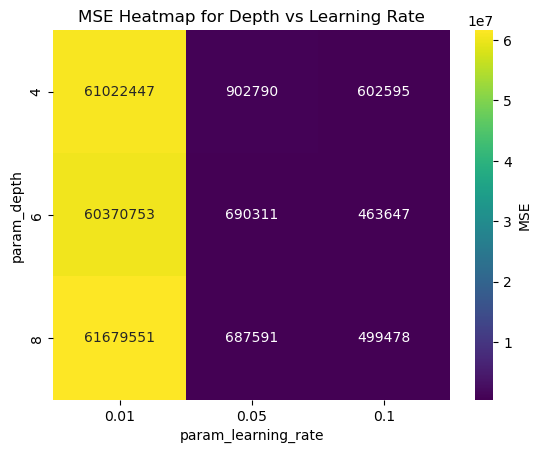

In [10]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

# Define the parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    CatBoostRegressor(iterations=100, silent=True),
    param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)


results = pd.DataFrame(grid_search.cv_results_)

# Create the pivot table with keyword arguments
heatmap_data = results.pivot(index="param_depth", columns="param_learning_rate", values="mean_test_score")

# Plot heatmap
sns.heatmap(-heatmap_data, annot=True, fmt=".0f", cmap="viridis", cbar_kws={'label': 'MSE'})
plt.title("MSE Heatmap for Depth vs Learning Rate")
plt.show()



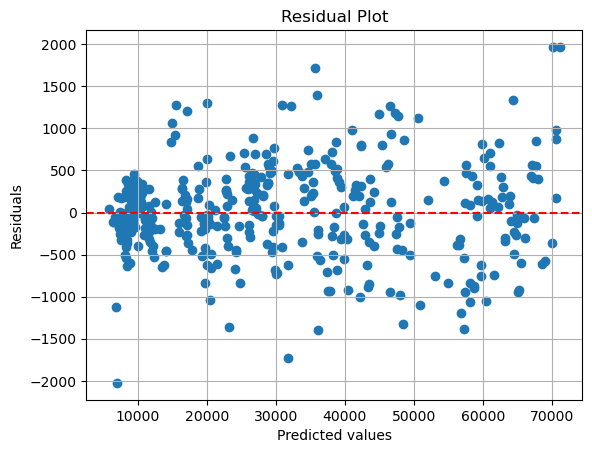

In [8]:
import matplotlib.pyplot as plt

# Fit model on full training data and predict
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculate residuals
residuals = y_test - predictions

# Plot residuals
plt.figure()
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid()
plt.show()


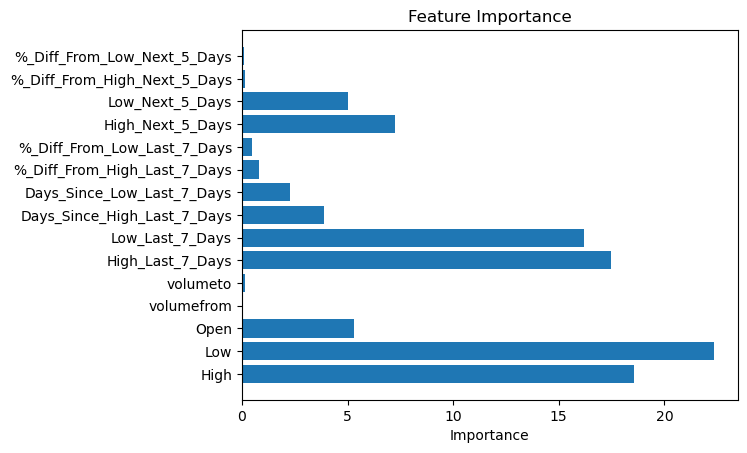

In [9]:
# Plot feature importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

plt.figure()
plt.barh(feature_names, feature_importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()


# Final model

In [13]:

# Drop unnecessary columns if not done yet
df = df.drop(columns=['conversionType', 'conversionSymbol'], errors='ignore')
import pandas as pd

# Assuming 'df' is your DataFrame and 'Date' is the column with concatenated dates
# Step 1: Check if dates are concatenated into a single string
if df['Date'].dtype == 'object':
    # If the dates are concatenated, try splitting them
    df['Date'] = df['Date'].apply(lambda x: [x[i:i+10] for i in range(0, len(x), 10)])

    # Flatten the lists into separate rows if needed
    df = df.explode('Date').reset_index(drop=True)

# Step 2: Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Now you can proceed with further analysis or operations

# Handle NaN values in 'High', 'Low', 'Open', etc. by filling with mean
df.fillna(df.mean(), inplace=True)


# Handle NaN values only for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Create lag features
for lag in range(1, 8):
    df[f'High_lag_{lag}'] = df['High'].shift(lag)
    df[f'Low_lag_{lag}'] = df['Low'].shift(lag)
    df[f'Open_lag_{lag}'] = df['Open'].shift(lag)
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    df[f'Volume_lag_{lag}'] = df['volumefrom'].shift(lag)

# Create target columns
df['High_Next_5_Days'] = df['High'].shift(-5)
df['Low_Next_5_Days'] = df['Low'].shift(-5)

# Drop rows with NaN values after shifting (usually at start and end of the dataset)
df = df.dropna().reset_index(drop=True)


In [14]:
# Define features and target variables
X = df.drop(columns=['High_Next_5_Days', 'Low_Next_5_Days'])
y_high = df['High_Next_5_Days']
y_low = df['Low_Next_5_Days']


In [15]:
# Split the data into training and test sets
X_train, X_test, y_train_high, y_test_high = train_test_split(X, y_high, test_size=0.2, random_state=42)
X_train, X_test, y_train_low, y_test_low = train_test_split(X, y_low, test_size=0.2, random_state=42)


In [18]:
# Define CatBoost Regressor
catboost_model = CatBoostRegressor(verbose=0)

# Parameter grid for tuning
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform grid search for best hyperparameters
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train_high)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters for High Prediction:", best_params)

# Train final model with best parameters for 'High_Next_5_Days' prediction
model_high = CatBoostRegressor(**best_params)
model_high.fit(X_train, y_train_high)
#saving the model
model_high.save_model('model_high.h5')


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters for High Prediction: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
0:	learn: 19315.5117352	total: 6.27ms	remaining: 6.26s
1:	learn: 19134.0917575	total: 10.5ms	remaining: 5.25s
2:	learn: 18959.1082617	total: 14.5ms	remaining: 4.81s
3:	learn: 18781.9767510	total: 18.5ms	remaining: 4.61s
4:	learn: 18609.0856102	total: 23.4ms	remaining: 4.66s
5:	learn: 18431.6841345	total: 27.2ms	remaining: 4.51s
6:	learn: 18257.4629982	total: 32ms	remaining: 4.54s
7:	learn: 18084.7537710	total: 37.2ms	remaining: 4.62s
8:	learn: 17918.0902208	total: 52.6ms	remaining: 5.79s
9:	learn: 17750.4168172	total: 58ms	remaining: 5.75s
10:	learn: 17584.8912137	total: 63.1ms	remaining: 5.68s
11:	learn: 17420.7309948	total: 69.7ms	remaining: 5.74s
12:	learn: 17259.1491429	total: 76.2ms	remaining: 5.78s
13:	learn: 17098.5702980	total: 82.8ms	remaining: 5.83s
14:	learn: 16941.0018449	total: 105ms	remaining: 6.89s
15

In [19]:
grid_search.fit(X_train, y_train_low)
best_params_low = grid_search.best_params_
print("Best Parameters for Low Prediction:", best_params_low)

# Train final model with best parameters for 'Low_Next_5_Days' prediction
model_low = CatBoostRegressor(**best_params_low)
model_low.fit(X_train, y_train_low)
model_low.save_model('model_low.h5')

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters for Low Prediction: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
0:	learn: 18404.3240586	total: 11.4ms	remaining: 11.3s
1:	learn: 18233.1866211	total: 19.1ms	remaining: 9.53s
2:	learn: 18061.9740851	total: 27.1ms	remaining: 9.02s
3:	learn: 17893.8473975	total: 34.8ms	remaining: 8.67s
4:	learn: 17726.4585052	total: 43.7ms	remaining: 8.69s
5:	learn: 17560.2568206	total: 52.7ms	remaining: 8.73s
6:	learn: 17396.1142620	total: 62ms	remaining: 8.79s
7:	learn: 17234.0562489	total: 71.6ms	remaining: 8.88s
8:	learn: 17074.0295414	total: 82.8ms	remaining: 9.12s
9:	learn: 16915.7820184	total: 94.6ms	remaining: 9.37s
10:	learn: 16756.2711142	total: 108ms	remaining: 9.74s
11:	learn: 16598.9196510	total: 124ms	remaining: 10.2s
12:	learn: 16442.2064522	total: 140ms	remaining: 10.6s
13:	learn: 16288.2218294	total: 158ms	remaining: 11.1s
14:	learn: 16137.1859492	total: 174ms	remaining: 11.4s
15:	l

In [20]:
# Predict on test set
y_pred_high = model_high.predict(X_test)
y_pred_low = model_low.predict(X_test)

# Calculate MSE and R2 for High and Low predictions
mse_high = mean_squared_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)
mse_low = mean_squared_error(y_test_low, y_pred_low)
r2_low = r2_score(y_test_low, y_pred_low)

print("High Prediction - MSE:", mse_high, "R2:", r2_high)
print("Low Prediction - MSE:", mse_low, "R2:", r2_low)


High Prediction - MSE: 1245392.9825517847 R2: 0.9969618321576159
Low Prediction - MSE: 1841988.237279434 R2: 0.9951271019715973


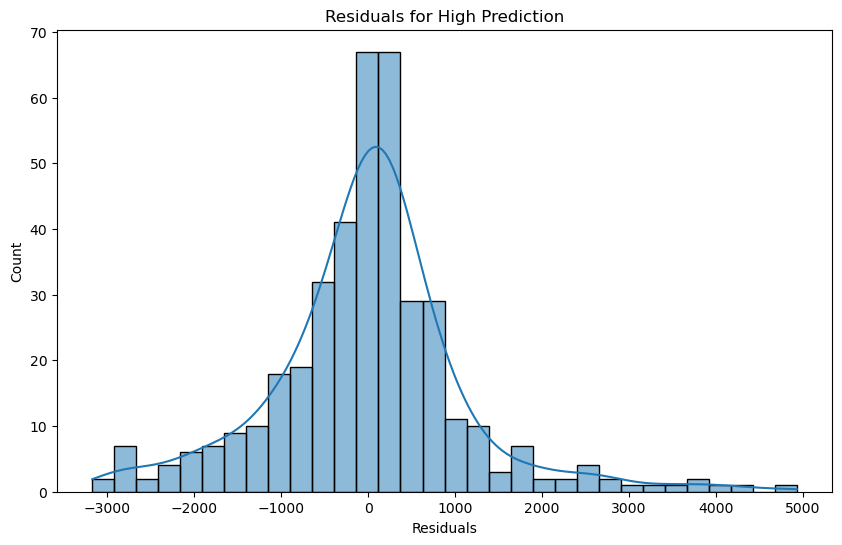

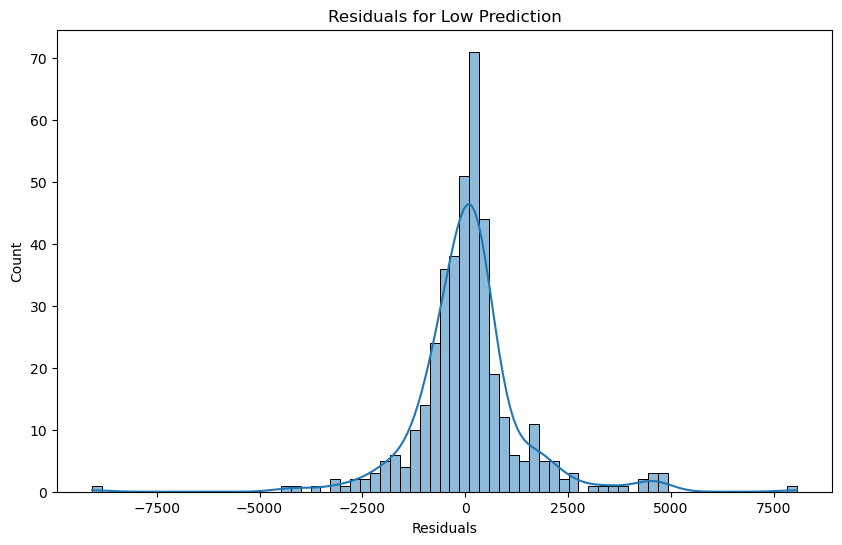

In [21]:
# Residuals for High prediction
residuals_high = y_test_high - y_pred_high
plt.figure(figsize=(10, 6))
sns.histplot(residuals_high, kde=True)
plt.title("Residuals for High Prediction")
plt.xlabel("Residuals")
plt.show()

# Residuals for Low prediction
residuals_low = y_test_low - y_pred_low
plt.figure(figsize=(10, 6))
sns.histplot(residuals_low, kde=True)
plt.title("Residuals for Low Prediction")
plt.xlabel("Residuals")
plt.show()


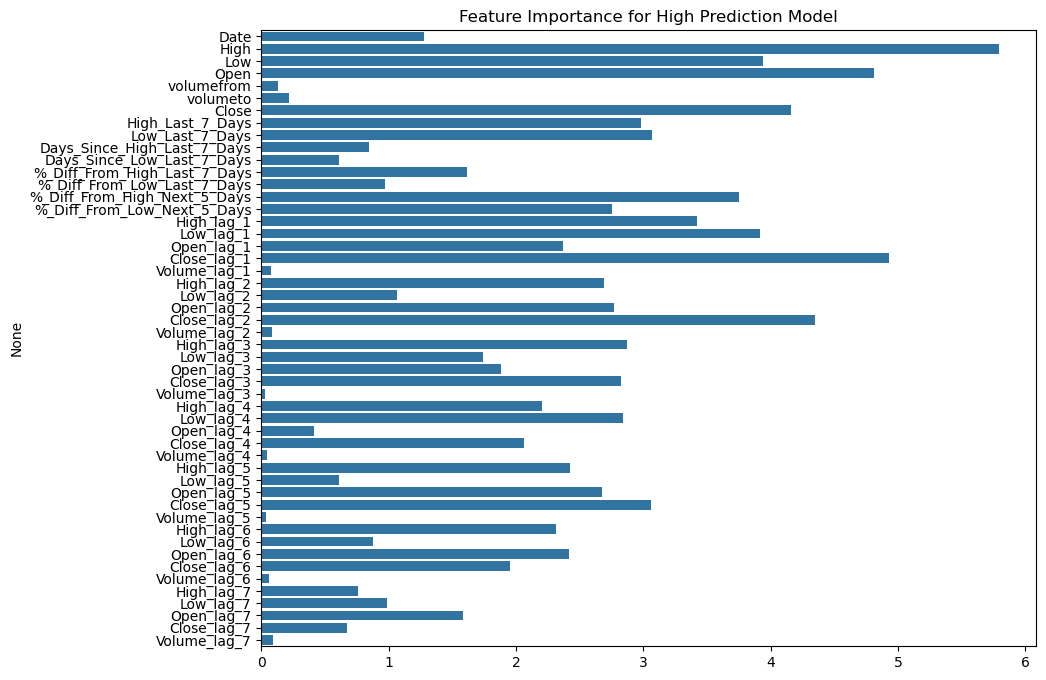

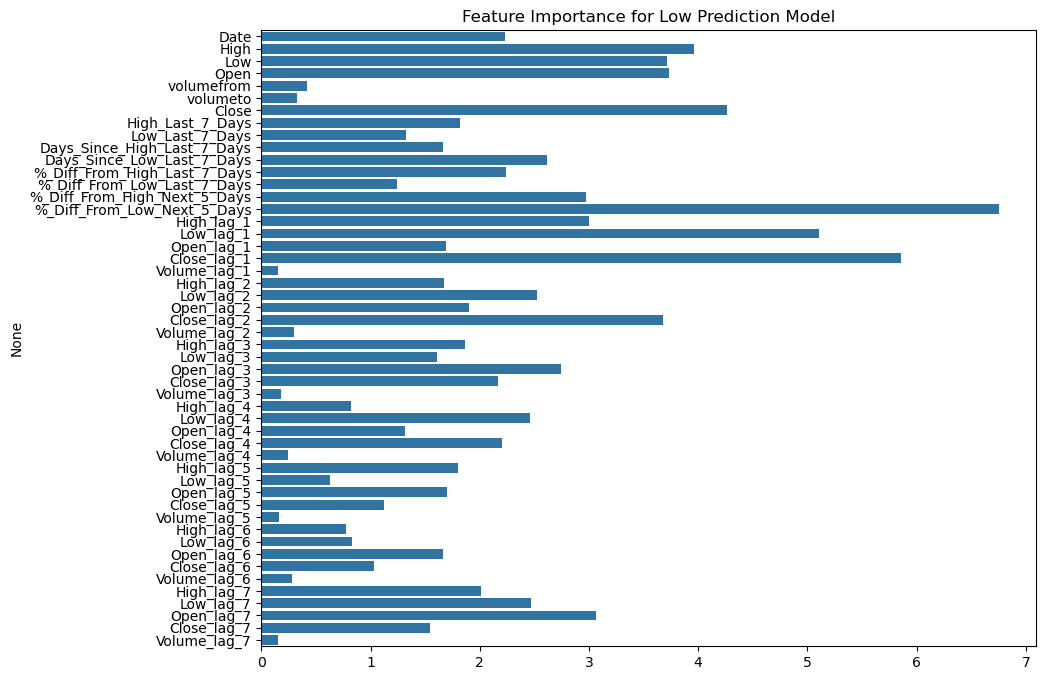

In [22]:
# Plot feature importance for 'High' model
plt.figure(figsize=(10, 8))
sns.barplot(x=model_high.feature_importances_, y=X.columns)
plt.title("Feature Importance for High Prediction Model")
plt.show()

# Plot feature importance for 'Low' model
plt.figure(figsize=(10, 8))
sns.barplot(x=model_low.feature_importances_, y=X.columns)
plt.title("Feature Importance for Low Prediction Model")
plt.show()
